# Twitter Sentiment Analysis with PySpark

In [1]:
# Import tweepy for now. We will import the rest of the libraries as we need them.
import tweepy 

# To stream live tweets, twitter API only needs the bearer token from your twitter developer account.
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAENsjwEAAAAAelLJV6LgU3wmmKcHcimv4Eo1cu4%3DWZjBje1CvP2GG8SsX15L7EN8iqVAPTyggzyprKh1gMGLRo3YQ1'

# We will create an empty list here to store all the incoming tweets.
incoming_tweets = []

# Subclass of StreamingClient that will use the functions written above to clean and classify sentiment of tweets before storing them in a csv.
class MyStreamer(tweepy.StreamingClient):        
    def on_tweet(self, tweet):
        incoming_tweets.append([tweet.id, tweet.text]) #only have tweet id and text in this tweet object
        if len(incoming_tweets) == 5000: #can set any number
            streamer.disconnect() #streamer will disconnect when the count of tweets you have set in the last line is reached
            
streamer = MyStreamer(bearer_token)
streamer.add_rules(tweepy.StreamRule("Saudi Arabia vs Mexico lang:en")) #can add a specific topic here

streamer.filter()

Stream connection closed by Twitter


In [3]:
#Check the list that contains all the incoming tweets
len(incoming_tweets)

5000

### Creating a DataFrame from Lists

We will now start a spark session. Followed by creating a spark dataframe using the list of tweets we created above and appropriate column names. 

In [4]:
# Necessary Imports
from pyspark.sql import SparkSession, SQLContext

# Build a spark session - driver's memory increased for training models later.
spark = SparkSession.builder.config("spark.driver.memory", "15g").appName('Tweets').getOrCreate()

# As we have only two columns -> id and text -> we will create a list called columns containing both.
columns = ['id', 'text']

# To create a spark dataframe, we will use the following method and pass incoming_tweets and columns lists as arguments.
df = spark.createDataFrame(incoming_tweets, columns)
df.show(10)

22/11/30 17:15:25 WARN Utils: Your hostname, Amjads-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.41 instead (on interface en0)
22/11/30 17:15:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/30 17:15:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-------------------+--------------------+
|                 id|                text|
+-------------------+--------------------+
|1597956829102874625|@MustBeAnxiety #S...|
|1597956829455474688|Love is what move...|
|1597956831414042625|@LiohNOO #Spotify...|
|1597956830705041408|World Cup #WhoAre...|
|1597956829644029952|@ofidiovenenoso #...|
|1597956831179161603|@LornaHay99 #Spot...|
|1597956829946195968|The learning proc...|
|1597956831669788673|@yagiyuseis #Spot...|
|1597956830931881986|@KSergatskova I w...|
|1597956831636525058|@MinionWestern @t...|
+-------------------+--------------------+
only showing top 10 rows



### Preprocessing

We will use TextBlob to get sentiment of the text of each tweet and we will use regular expression (regex) to clean tweets from special characters, links, etc. We will do this by creating functions that we can apply to entire dataframe columns.

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(RT)", " ", tweet).split())


def varder_analysis(text):
    score = SentimentIntensityAnalyzer().polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.5:
        return 'Negative'
    else:
        return 'Neutral'


from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
spark.udf.register("clean_tweet", clean_tweet)
clean_tweet_udf = udf(lambda x: clean_tweet(x), StringType())
df = df.select("id", "text", clean_tweet_udf("text").alias("cleaned_text")) #you can use .alias() to rename the output column

spark.udf.register("varder_analysis", varder_analysis)
varder_analysis_udf = udf(lambda x: varder_analysis(x), StringType())
df = df.select("id", "cleaned_text", varder_analysis_udf("cleaned_text"))
df.show()

+-------------------+--------------------+----------------------+
|                 id|        cleaned_text|<lambda>(cleaned_text)|
+-------------------+--------------------+----------------------+
|1597956829102874625|SpotifyWrapped is...|               Neutral|
|1597956829455474688|Love is what move...|              Positive|
|1597956831414042625|SpotifyWrapped is...|               Neutral|
|1597956830705041408|World Cup WhoAreY...|               Neutral|
|1597956829644029952|SpotifyWrapped is...|               Neutral|
|1597956831179161603|SpotifyWrapped is...|               Neutral|
|1597956829946195968|The learning proc...|              Negative|
|1597956831669788673|SpotifyWrapped is...|               Neutral|
|1597956830931881986|I want to know wh...|              Positive|
|1597956831636525058|The EU is not tur...|              Positive|
|1597956829849751552|1 in 6 grown men ...|              Negative|
|1597956828406906880|Guendouzi startin...|               Neutral|
|159795682

### Storing as a CSV

In [6]:
#df.write.format("csv").save("tweetsss")
df.toPandas().to_csv("tweets.csv", header=True, index=False)

In [2]:
# Necessary Imports
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SparkSession, SQLContext
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Build a spark session - driver's memory increased for training models later. 
spark = SparkSession.builder.config("spark.driver.memory", "15g").appName('TweetsTable').getOrCreate()

22/11/30 17:41:25 WARN Utils: Your hostname, Amjads-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.41 instead (on interface en0)
22/11/30 17:41:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/30 17:41:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Loading Data

We will read first by Pandas to be able to do visualizations.

In [3]:
# Read first by Pandas
df = pd.read_csv("tweets.csv")

In [4]:
df = df.rename(columns={'<lambda>(cleaned_text)':'sentiment'})
df

,id,cleaned_text,sentiment
0,1597956829102874625,SpotifyWrapped is here Share yours with the wo...,Neutral
1,1597956829455474688,Love is what moves the world I ve always thoug...,Positive
2,1597956831414042625,SpotifyWrapped is here Share yours with the wo...,Neutral
3,1597956830705041408,World Cup WhoAreYa 16 7 8 PlayFootballGames,Neutral
4,1597956829644029952,SpotifyWrapped is here Share yours with the wo...,Neutral
...,...,...,...
4995,1597957264551337991,SpotifyWrapped is here Share yours with the wo...,Neutral
4996,1597957263108579329,SpotifyWrapped is here Share yours with the wo...,Neutral
4997,1597957247346348040,SpotifyWrapped is here Share yours with the wo...,Neutral
4998,1597957246436413440,It doesn t seem to take much to get to his maj...,Neutral


### Data Exploration

Let's see if there are any null values in our dataset before we can visualize the sentiments.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5000 non-null   int64 
 1   cleaned_text  4990 non-null   object
 2   sentiment     5000 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [6]:
df

,id,cleaned_text,sentiment
0,1597956829102874625,SpotifyWrapped is here Share yours with the wo...,Neutral
1,1597956829455474688,Love is what moves the world I ve always thoug...,Positive
2,1597956831414042625,SpotifyWrapped is here Share yours with the wo...,Neutral
3,1597956830705041408,World Cup WhoAreYa 16 7 8 PlayFootballGames,Neutral
4,1597956829644029952,SpotifyWrapped is here Share yours with the wo...,Neutral
...,...,...,...
4995,1597957264551337991,SpotifyWrapped is here Share yours with the wo...,Neutral
4996,1597957263108579329,SpotifyWrapped is here Share yours with the wo...,Neutral
4997,1597957247346348040,SpotifyWrapped is here Share yours with the wo...,Neutral
4998,1597957246436413440,It doesn t seem to take much to get to his maj...,Neutral


Text(0.5, 1.0, 'Class disturbuation')

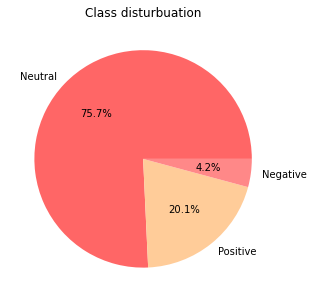

In [7]:
#class disturbation 
colors = ['#ff6666', '#ffcc99','#ff8888']
labels = 'Neutral','Positive','Negative'
plt.figure(figsize=(13,5))
class_dis = plt.pie(df['sentiment'].value_counts(),labels = labels,autopct='%1.1f%%',colors=colors)
plt.title('Class disturbuation')

We have an imbalanced class distribution problem

In [30]:
data_pos = df[df['sentiment']=='Positive']
data_neg = df[df['sentiment']=='Negative']

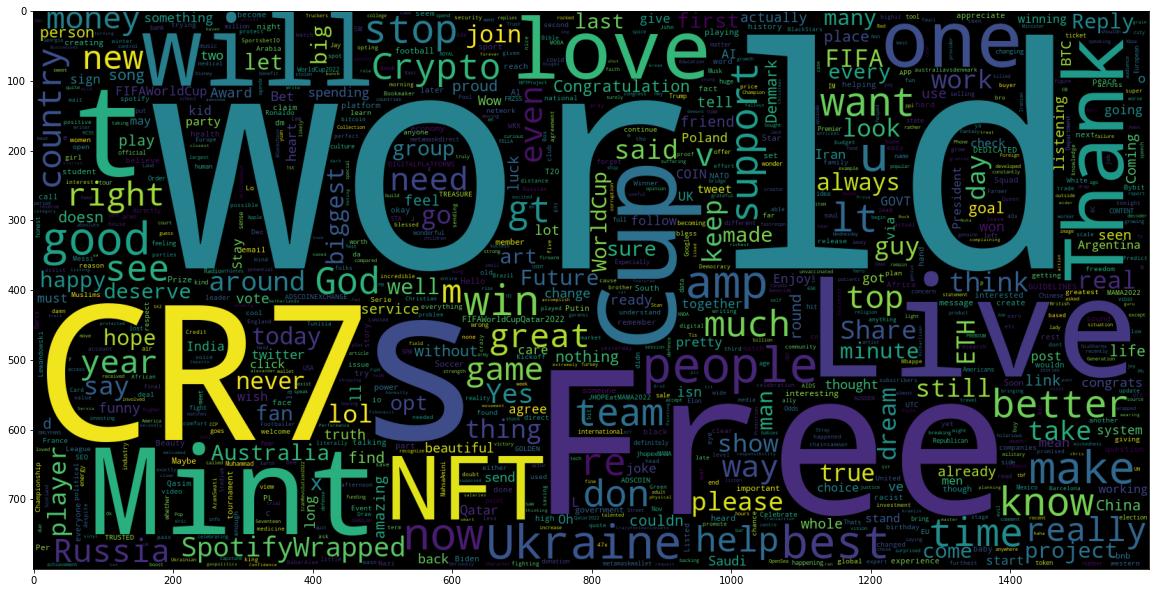

In [31]:
# We will now take only the cleaned_text column to base our word cloud on for tweets with positive sentiment.
data_pos = data_pos['cleaned_text']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

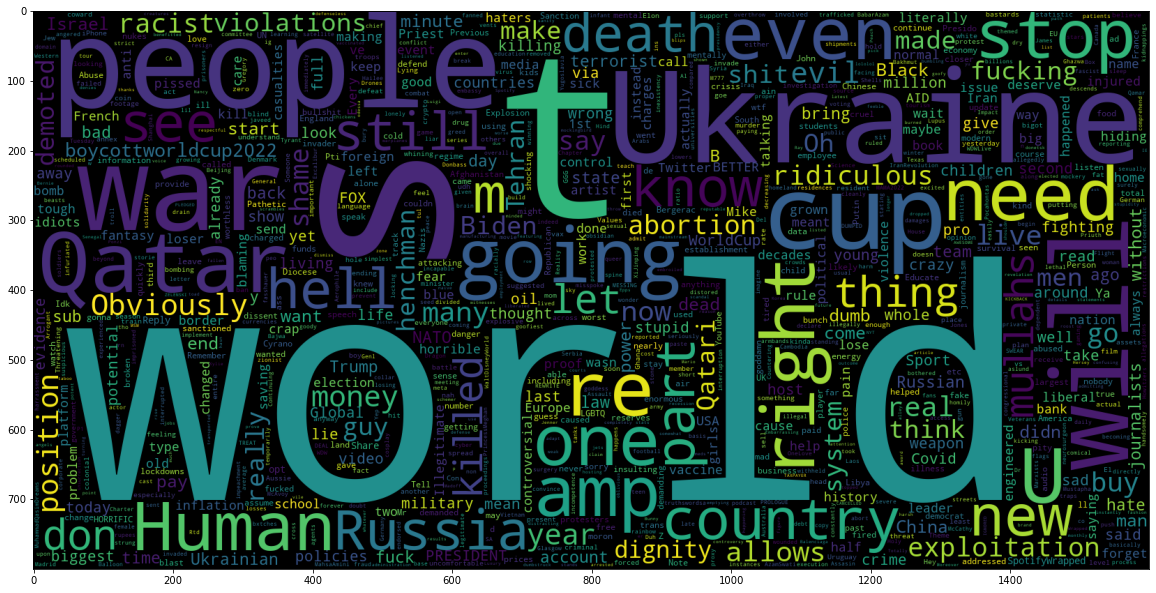

In [32]:
# We will do the same for tweets with negative sentiment
data_neg = data_neg['cleaned_text']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### Model Building
Now let's switch to PySpark for preprocessing the data to prepare it for model building.

In [8]:
# Necessary imports
import pyspark.sql.dataframe
from pyspark.sql.functions import regexp_replace, col, lower
from pyspark.sql.types import *
from pyspark.ml.feature import *

# Convert Pandas dataframe to Spark dataframe
schema = StructType([\
    StructField("id", LongType(), True),\
    StructField("text", StringType(), True),\
    StructField("sentiment", StringType(), True)])

df_spark = spark.createDataFrame(df, schema=schema)

In [9]:
df_spark.show()

+-------------------+--------------------+---------+
|                 id|                text|sentiment|
+-------------------+--------------------+---------+
|1597956829102874625|SpotifyWrapped is...|  Neutral|
|1597956829455474688|Love is what move...| Positive|
|1597956831414042625|SpotifyWrapped is...|  Neutral|
|1597956830705041408|World Cup WhoAreY...|  Neutral|
|1597956829644029952|SpotifyWrapped is...|  Neutral|
|1597956831179161603|SpotifyWrapped is...|  Neutral|
|1597956829946195968|The learning proc...| Negative|
|1597956831669788673|SpotifyWrapped is...|  Neutral|
|1597956830931881986|I want to know wh...| Positive|
|1597956831636525058|The EU is not tur...| Positive|
|1597956829849751552|1 in 6 grown men ...| Negative|
|1597956828406906880|Guendouzi startin...|  Neutral|
|1597956828964737025|Good afternoon Ki...| Positive|
|1597956830101217280|SpotifyWrapped is...|  Neutral|
|1597956830726176769|Iranian protester...|  Neutral|
|1597956828863815680|SpotifyWrapped is...|  Ne

#### Preprocessing
We will replace positive sentiment with 1, negative with 0, and neutral with 2. We will then need to convert the sentiment column from String Type to Integer Type.

In [10]:
df_spark = df_spark.withColumn('sentiment', regexp_replace('sentiment', 'Positive', '1')) # positive -> 1
df_spark = df_spark.withColumn('sentiment', regexp_replace('sentiment', 'Negative', '0')) # negative -> 0
df_spark = df_spark.withColumn('sentiment', regexp_replace('sentiment', 'Neutral', '2'))  # neutral -> 2

df_spark = df_spark.withColumn("sentiment",col("sentiment").cast("integer")) # convert column from string to int

df_spark.printSchema()

root
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- sentiment: integer (nullable = true)



Now we will lower the text in the text column and store it in a separate column.

In [11]:
df_spark = df_spark.select("*", lower(col('text')))

In [12]:
df_spark.show()

+-------------------+--------------------+---------+--------------------+
|                 id|                text|sentiment|         lower(text)|
+-------------------+--------------------+---------+--------------------+
|1597956829102874625|SpotifyWrapped is...|        2|spotifywrapped is...|
|1597956829455474688|Love is what move...|        1|love is what move...|
|1597956831414042625|SpotifyWrapped is...|        2|spotifywrapped is...|
|1597956830705041408|World Cup WhoAreY...|        2|world cup whoarey...|
|1597956829644029952|SpotifyWrapped is...|        2|spotifywrapped is...|
|1597956831179161603|SpotifyWrapped is...|        2|spotifywrapped is...|
|1597956829946195968|The learning proc...|        0|the learning proc...|
|1597956831669788673|SpotifyWrapped is...|        2|spotifywrapped is...|
|1597956830931881986|I want to know wh...|        1|i want to know wh...|
|1597956831636525058|The EU is not tur...|        1|the eu is not tur...|
|1597956829849751552|1 in 6 grown men 

In [13]:
df_spark = df_spark.select("lower(text)", "sentiment")
df_spark = df_spark.withColumnRenamed("lower(text)","text")

In [14]:
df_spark.show()

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|spotifywrapped is...|        2|
|love is what move...|        1|
|spotifywrapped is...|        2|
|world cup whoarey...|        2|
|spotifywrapped is...|        2|
|spotifywrapped is...|        2|
|the learning proc...|        0|
|spotifywrapped is...|        2|
|i want to know wh...|        1|
|the eu is not tur...|        1|
|1 in 6 grown men ...|        0|
|guendouzi startin...|        2|
|good afternoon ki...|        1|
|spotifywrapped is...|        2|
|iranian protester...|        2|
|spotifywrapped is...|        2|
|they took the pur...|        1|
|spotifywrapped is...|        2|
|slowly pushes the...|        2|
|spotifywrapped is...|        2|
+--------------------+---------+
only showing top 20 rows



### Splitting

Before we can begin training, we will split the dataset into training and testing sets.

In [15]:
#Split training and Testing.
split_data=df_spark.randomSplit([0.8,0.2])
train=split_data[0]

#label in test renamed to true label.
test=split_data[1].withColumnRenamed("sentiment","true_sentiment")
train_rows=train.count()
test_rows=test.count()

print("Total train :",train_rows)
print("Total test :", test_rows)

Total train : 3972
Total test : 1028


### More Processing

In [16]:
# Tokening the text column would separate each word in a tweet and make one tweet a list of words.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenized_train = tokenizer.transform(df_spark)
tokenized_train.show(truncate=True, n=5)

+--------------------+---------+--------------------+
|                text|sentiment|               words|
+--------------------+---------+--------------------+
|spotifywrapped is...|        2|[spotifywrapped, ...|
|love is what move...|        1|[love, is, what, ...|
|spotifywrapped is...|        2|[spotifywrapped, ...|
|world cup whoarey...|        2|[world, cup, whoa...|
|spotifywrapped is...|        2|[spotifywrapped, ...|
+--------------------+---------+--------------------+
only showing top 5 rows



In [17]:
# Stop Words Remover will remove all less meaning words like helping verbs, etc.
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="MeaningfulWords")
SwRemoved_train = swr.transform(tokenized_train)
SwRemoved_train.show(truncate=True, n=5)

22/11/30 17:42:48 WARN StopWordsRemover: Default locale set was [en_SA]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
+--------------------+---------+--------------------+--------------------+
|                text|sentiment|               words|     MeaningfulWords|
+--------------------+---------+--------------------+--------------------+
|spotifywrapped is...|        2|[spotifywrapped, ...|[spotifywrapped, ...|
|love is what move...|        1|[love, is, what, ...|[love, moves, wor...|
|spotifywrapped is...|        2|[spotifywrapped, ...|[spotifywrapped, ...|
|world cup whoarey...|        2|[world, cup, whoa...|[world, cup, whoa...|
|spotifywrapped is...|        2|[spotifywrapped, ...|[spotifywrapped, ...|
+--------------------+---------+--------------------+--------------------+
only showing top 5 rows



In [18]:
# Hashing TF will convert the meaningful words into numerical features.
hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
numeric_train = hashTF.transform(SwRemoved_train).select('sentiment', 'MeaningfulWords', 'features')
numeric_train.show(truncate=True, n=3)

+---------+--------------------+--------------------+
|sentiment|     MeaningfulWords|            features|
+---------+--------------------+--------------------+
|        2|[spotifywrapped, ...|(262144,[42835,60...|
|        1|[love, moves, wor...|(262144,[14273,49...|
|        2|[spotifywrapped, ...|(262144,[42835,60...|
+---------+--------------------+--------------------+
only showing top 3 rows



### Lets build some models!

We will be using Decision Trees, Random Forests, and Naive Bayes as our classifiers and we will use PySpark's own MulticlassClassificationEvaluator to evaluate these classifiers.

In [19]:
# Import some classifiers and multiclass evaluator as we have three classes -> positive, negative, and neutral.
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [20]:
# Decision Tree
dt = DecisionTreeClassifier(labelCol="sentiment", featuresCol="features")
model_dt = dt.fit(numeric_train)

22/11/30 17:44:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/11/30 17:45:26 WARN DAGScheduler: Broadcasting large task binary with size 1033.7 KiB


22/11/30 17:45:27 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/11/30 17:45:55 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/11/30 17:46:05 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/11/30 17:46:15 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/11/30 17:46:27 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


In [21]:
# Random Forest
rf = RandomForestClassifier(labelCol="sentiment", featuresCol="features", numTrees=10)
model_rf = rf.fit(numeric_train)

22/11/30 17:46:39 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/11/30 17:47:31 WARN DAGScheduler: Broadcasting large task binary with size 1033.7 KiB


22/11/30 17:47:31 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/11/30 17:47:53 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/11/30 17:47:58 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/11/30 17:48:08 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/11/30 17:48:15 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


In [22]:
# Naive Bayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", labelCol="sentiment", featuresCol="features")
model_nb = nb.fit(numeric_train)

Now we need to apply the processing steps we applied to the training set to the testing set.

In [23]:
# Prepare Testing data by putting it through the tokenizer, the stop words remover, and the hashing step we did earlier.
tokenized_test = tokenizer.transform(test)
SwRemoved_test = swr.transform(tokenized_test)
numeric_test = hashTF.transform(SwRemoved_test)
numeric_test.show(truncate=True, n=2)

+--------------------+--------------+--------------------+--------------------+--------------------+
|                text|true_sentiment|               words|     MeaningfulWords|            features|
+--------------------+--------------+--------------------+--------------------+--------------------+
|0 spotifywrapped ...|             2|[0, spotifywrappe...|[0, spotifywrappe...|(262144,[42835,60...|
|18 99 memox 10 mg...|             1|[18, 99, memox, 1...|[18, 99, memox, 1...|(262144,[10988,62...|
+--------------------+--------------+--------------------+--------------------+--------------------+
only showing top 2 rows



Lets now generate predictions by each model we produced earlier on the testing set.

In [24]:
# Predictions on the testing set.
pred_dt = model_dt.transform(numeric_test)
pred_rf = model_rf.transform(numeric_test)
pred_nb = model_nb.transform(numeric_test)

### Evaluation

For evaluation, we will be using simple accuracy metric along with F1, Weighted Precision and Weighted Recall (as the classes are imbalanced).

In [25]:
# Accuracy Metric
evaluator_A = MulticlassClassificationEvaluator(labelCol="true_sentiment", predictionCol="prediction", metricName="accuracy")

# F1 Metric
evaluator_F = MulticlassClassificationEvaluator(labelCol="true_sentiment", predictionCol="prediction", metricName="f1")

# Weighted Precision
evaluator_P = MulticlassClassificationEvaluator(labelCol="true_sentiment", predictionCol="prediction", metricName="weightedPrecision")

# Weighted Recall
evaluator_R = MulticlassClassificationEvaluator(labelCol="true_sentiment", predictionCol="prediction", metricName="weightedRecall")

# Our models
models = [pred_dt, pred_rf, pred_nb]

# Empty lists that will store the scores for each metric for each model.
accuracy = []
F1 = []
precision = []
recall = []

# Simple loop to populate the empty lists with scores of models for each metric.
for model in models:
    accuracy.append(evaluator_A.evaluate(model))
    F1.append(evaluator_F.evaluate(model))
    precision.append(evaluator_P.evaluate(model))
    recall.append(evaluator_R.evaluate(model))

22/11/30 17:49:29 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/11/30 17:49:29 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
22/11/30 17:49:29 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/11/30 17:49:29 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/11/30 17:49:29 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


In [26]:
# We will convert all lists created above into a dataframe for easy viewing.
df_ev = pd.DataFrame(list(zip(accuracy, F1, precision, recall)), 
                     columns = ['Accuracy', 'F1 score', 'Weighted Precision', 'Weighted Recall'],
                     index = ['Decision Tree', 'Random Forest', 'Naive Bayes'])

In [27]:
df_ev

,Accuracy,F1 score,Weighted Precision,Weighted Recall
Decision Tree,0.811284,0.765974,0.795616,0.811284
Random Forest,0.747082,0.638930,0.558131,0.747082
Naive Bayes,0.962062,0.956542,0.964065,0.962062


## Based on the metrices the Naive Bayes is the best model 